In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
txn_df = pickle.load(open('Results/txn_df.p','rb'))

In [4]:
gene_df = pickle.load(open('Results/gene_df.p','rb'))

In [5]:
gene_id_df = pickle.load(open('Results/gene_id_df.p','rb'))

In [6]:
## Only use genes with a peak
gene_df = gene_df[gene_df['hasGene']]

### Load gene_tissue_matrix

In [7]:
gene_tissue_matrix = pd.read_csv('Results/merged/genes_tissues.csv',index_col=0)
gene_tissue_matrix.fillna(0,inplace=True)
## Remove the genes with no peaks, if any
gene_tissue_matrix = gene_tissue_matrix[~(gene_tissue_matrix==0).all(axis=1)]
gene_tissue_matrix.head()

,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Brain/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Heart/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Kidney/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Liver/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Liver/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Lung/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Muscle/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Pancreas/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Spleen/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Spleen/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/CHO/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/CHO/mSTART/f04_peaks/merge_bg_2.peak
SERHL,9.020000,33.00,45.349998,66.449997,45.200001,1666.349976,36.900002,29.050001,29.00,26.314999,54.650002,44.0,18.90,15.650,96.550003,76.000000
RRP7A,0.000000,2.50,2.455000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00,10.105,0.000000,3.890000
POLDIP3,10.100000,12.80,33.150002,7.010000,8.690000,0.000000,8.380000,0.000000,13.80,0.000000,9.530000,0.0,13.50,9.395,31.700001,34.799999
CYB5R3,4.510000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000,0.000000,0.897000
A4GALT,25.700001,5.91,0.000000,30.750000,8.480000,4.970000,0.000000,0.000000,9.46,0.000000,26.100000,0.0,3.07,2.715,0.000000,0.000000


### Different ways to separate in CHO and not in CHO
1. Genes expressed in at least one tissue and not in CHO
2. Genes that were expressed in every other tissue and not in CHO samples.    
3. Genes expressed in >= 50% of the tissues and not in CHO samples.  
4. Genes with counts greater than 10 in every other tissue and CHO has counts less than 10.  
5. Genes with counts greater than 10 in >= 50% of the tissue and CHO has counts less than 10.  

In [8]:
#######################################
## Merge the tissues together to take the max. 
def merge_tissues(tissue_df,tissues):
    ''' Merging samples with the same tissue'''
    gene_tissue_df = pd.DataFrame(index=tissue_df.index,columns=tissues)
    for t in tissues:
        curr_cols = tissue_df.loc[:,tissue_df.columns.str.contains(t)]
        gene_tissue_df.at[:,t] = curr_cols.max(axis=1)

    gene_tissue_df = gene_tissue_df.loc[:,~((gene_tissue_df.isnull()).all(axis=0))] #if any tissues were not processed
    
    return gene_tissue_df


#######################################
def at_least_one_not_cho(tissue_df,cho_df):
    '''Parameters:
        tissue_df: The gene-by-tissue expression matrix. Sample names should have tissue in name
        tissues: List of tissues to consider.
        cho_df: Same rows, but columns are the cho samples.
        A tissue could have more than one sample, and if at least one is present then it is ok.'''
    
    in_cho = cho_df[((cho_df>0).any(axis=1))].index.values
    not_in_cho = tissue_df[((tissue_df>0).any(axis=1)) & ((cho_df==0).all(axis=1))].index.values
    
    return in_cho, not_in_cho


#######################################
def all_but_cho(tissue_df,cho_df):
    '''Parameters:
        tissue_df: The gene-by-tissue expression matrix. Sample names should have tissue in name
        tissues: List of tissues to consider.
        cho_df: Same rows, but columns are the cho samples.
        A tissue could have more than one sample, and if at least one is present then it is ok.'''
    
    in_cho = cho_df[((cho_df>0).any(axis=1))].index.values
    not_in_cho = tissue_df[((tissue_df>0).all(axis=1)) & ((cho_df==0).all(axis=1))].index.values
    
    return in_cho, not_in_cho


#######################################
def half_and_not_cho(tissue_df,cho_df):
    '''Parameters:
        tissue_df: The genexsample expression matrix. 
        A tissue could have more than one sample, and if at least one is present then it is ok.
    '''
    
    fifty = len(tissues)/2
    in_cho = cho_df[((cho_df>0).any(axis=1))].index.values
    not_in_cho = tissue_df[(np.sum(tissue_df>0,axis=1)>fifty) & ((cho_df==0).all(axis=1))].index.values
    
    return in_cho, not_in_cho



#######################################
def count_n_all_but_cho(tissue_df,cho_df,n=10):
    '''Parameters:
        tissue_df: The genexsample expression matrix. 
        A tissue could have more than one sample, and if at least one is present then it is ok.
    '''
    
    in_cho = cho_df[((cho_df>n).any(axis=1))].index.values
    not_in_cho = tissue_df[(np.sum(tissue_df>n,axis=1)==tissue_df.shape[1]) & ((cho_df<=n).all(axis=1))].index.values
    
    return in_cho, not_in_cho

#######################################
def count_ten_half_and_not_cho(tissue_df,cho_df,n=10):
    '''Parameters:
        tissue_df: The genexsample expression matrix. 
        A tissue could have more than one sample, and if at least one is present then it is ok.
    '''
    
    fifty = len(tissues)/2
    in_cho = cho_df[((cho_df>n).any(axis=1))].index.values
    not_in_cho = tissue_df[(np.sum(tissue_df>n,axis=1) >fifty) & ((cho_df <= 0).all(axis=1))].index.values
    
    return in_cho, not_in_cho

In [9]:
gene_tissue_df = merge_tissues(gene_tissue_matrix,tissues)
cho = gene_tissue_df.loc[:,'CHO']
cho = pd.DataFrame(cho)
gene_tissue_df = gene_tissue_df.drop('CHO',axis=1) #Remove CHO columns

In [10]:
gene_tissue_df

,BMDMwt,Brain,Heart,Kidney,Liver,Lung,Muscle,Pancreas,Spleen
SERHL,9.020000,45.349998,66.449997,1666.349976,36.900002,29.000000,54.650002,44.000000,18.900000
RRP7A,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.105000
POLDIP3,10.100000,33.150002,7.010000,8.690000,8.380000,13.800000,9.530000,0.000000,13.500000
CYB5R3,4.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,25.700001,5.910000,30.750000,8.480000,0.000000,9.460000,26.100000,0.000000,3.070000
ARFGAP3,45.799999,59.000000,0.000000,171.500000,307.899994,28.200001,0.000000,0.000000,35.200001
PACSIN2,77.000000,58.000000,184.149994,119.300003,81.199997,1197.349976,101.399994,43.900002,81.599998
TTLL1,27.600000,112.500000,13.610001,158.300003,50.299999,122.500000,13.200000,9.980000,66.300003
BIK,0.000000,0.000000,0.000000,0.000000,3.350000,0.000000,0.000000,0.000000,0.000000
MCAT,2.440000,1.670000,0.000000,3.140000,0.000000,5.480000,0.000000,0.000000,5.590000


In [11]:
cho

,CHO
SERHL,96.550003
RRP7A,3.890000
POLDIP3,34.799999
CYB5R3,0.897000
A4GALT,0.000000
ARFGAP3,36.250000
PACSIN2,60.599998
TTLL1,0.000000
BIK,19.500000
MCAT,12.450000


In [12]:
in_cho1, not_in_cho1 = at_least_one_not_cho(gene_tissue_df,cho)
print('1')
print(len(in_cho1))
print(len(not_in_cho1))

1
7140
4414


In [13]:
in_cho2, not_in_cho2 = all_but_cho(gene_tissue_df,cho)
print('2')
print(len(in_cho2))
print(len(not_in_cho2))

2
7140
79


In [14]:
in_cho3, not_in_cho3 = half_and_not_cho(gene_tissue_df,cho)
print('3')
print(len(in_cho3))
print(len(not_in_cho3))

3
7140
79


In [15]:
in_cho4, not_in_cho4 = count_n_all_but_cho(gene_tissue_df,cho)
print('4')
print(len(in_cho4))
print(len(not_in_cho4))

4
4561
16


In [16]:
in_cho5, not_in_cho5 = count_ten_half_and_not_cho(gene_tissue_df,cho)
print('5')
print(len(in_cho5))
print(len(not_in_cho5))

5
4561
4


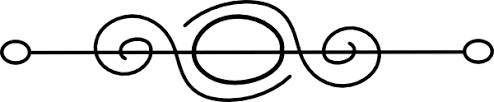

In [17]:
from IPython.display import Image
Image(filename='/home/isshamie/chapter_break.png')

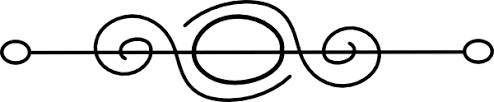

In [29]:
from IPython.display import Image
Image(filename='/home/isshamie/chapter_break.png')

## Load in KEGG genes: 
#### Protein processing in Endoplasmic Reticulum

In [17]:
import xml.etree.ElementTree as et

#### Convert from id to symbol

In [18]:
gene2refseq = pd.read_csv('supplemental/gene2refseq',sep='\t',header=0,
                         usecols=['GeneID','Symbol'])

In [19]:
er_f = 'supplemental/cge04141.xml'

er = set()
tree = et.parse(er_f )
root = tree.getroot()
for child in root:
    #print child.tag, child.attrib
    if 'name' in child.attrib and 'cge:' in child.attrib['name'] : 
        er.add(child.attrib['name'].split(':')[1].split()[0]) #Take the first cge:number 
        

er_symbol = set()
er_symbol_dict = dict()
for i in er:
    for j in gene2refseq[gene2refseq['GeneID'] == int(i)]['Symbol']:
        er_symbol_dict[j.upper()] = i
        er_symbol.add(j)
        
er_symbol = set(map(lambda x: x.upper(),er_symbol))


print(er_symbol.intersection(set(in_cho1)))

print(er_symbol.intersection(set(not_in_cho1)))

print(er_symbol.intersection(set(not_in_cho2)))

print(er_symbol.intersection(set(not_in_cho3)))

print(er_symbol.intersection(set(not_in_cho4)))

print(er_symbol.intersection(set(not_in_cho5)))


for i in (er_symbol.intersection(set(not_in_cho1))):
    print(er_symbol_dict[i])

set(['CALR', 'RAD23A', 'HSPA8', 'TRAF2', 'MARCH6', 'MAP2K7', 'PREB', 'NGLY1', 'CANX', 'XBP1', 'HERPUD1', 'STUB1', 'EIF2S1', 'SYVN1', 'DERL1', 'DERL2', 'UBE2G2', 'DNAJC10', 'RRBP1', 'UGGT2', 'ERN1', 'OS9', 'SEL1L', 'DDIT3', 'PDIA3', 'UBXN6', 'UBE4B', 'DNAJA1', 'MBTPS1', 'MOGS', 'ERO1A', 'TRAM1', 'SELENOS', 'SSR4', 'RBX1', 'ATF6B', 'WFS1', 'ATXN3', 'CKAP4', 'BCL2'])
set(['P4HB', 'SEC23A', 'NFE2L2', 'ERLEC1', 'LMAN2', 'HSP90AA1', 'VCP', 'EDEM1', 'SVIP', 'ATF4', 'NPLOC4', 'STT3A'])
set(['SVIP'])
set(['SVIP'])
set([])
set([])
100689433
100755854
100752102
100767274
100772915
100689397
103161970
100689456
100765826
100689386
100754863
100751391


### Prepare for KEGG Map

In [24]:
print gene_df[gene_df['gene'] == 'HSPA5']
gene_df[gene_df['gene'] == 'SERHL']
gene_df.head()

Empty DataFrame
Columns: [peaks, numberOfPeaks, peaksWithin_1kb_100bp, promoterPeaks, tissues, minDistance, minDistancePeak, maxValue, maxPeakId, maxTissues, Chr, Start, End, gene_id, gene, transcript, hasGene, Number of SS]
Index: []


,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...",10,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31,Merged-picr_0-20959-16,1666.35,Merged-picr_74-10067746-3,"[Heart_mSTART, Kidney_GRO, Kidney_mSTART]",picr_74,10067654,10067857,gene_26628_1,SERHL,asmbl_75212,True,2
RRP7A,"[Merged-picr_10-20507337-4, Merged-picr_0-4463...",26,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4]",[Merged-picr_0-44487-4],"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,gene_2,RRP7A,asmbl_10,True,1
POLDIP3,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98958-1...",[Merged-picr_0-78299-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41,Merged-picr_0-78299-12,34.8,Merged-picr_0-78299-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,78177,78416,gene_3_1,POLDIP3,asmbl_19,True,1
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-92664-2]","[BMDMwt_GRO, CHO_mSTART]",0,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,gene_3_2,CYB5R3,asmbl_20,True,2
A4GALT,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-5]","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,gene_4_3,A4GALT,asmbl_30,True,2


In [59]:
'SERHL' in gene_df.index

True

In [56]:
'HSPA5' in gene_df

False

In [29]:
er

{'100689032',
 '100689062',
 '100689085',
 '100689096',
 '100689098',
 '100689230',
 '100689305',
 '100689308',
 '100689343',
 '100689345',
 '100689381',
 '100689386',
 '100689397',
 '100689417',
 '100689433',
 '100689456',
 '100689462',
 '100689472',
 '100750680',
 '100751353',
 '100751391',
 '100751465',
 '100752102',
 '100752162',
 '100752376',
 '100752477',
 '100754332',
 '100754361',
 '100754421',
 '100754529',
 '100754863',
 '100755526',
 '100755627',
 '100755854',
 '100756512',
 '100756826',
 '100757519',
 '100757523',
 '100757595',
 '100757625',
 '100757677',
 '100757763',
 '100757909',
 '100757912',
 '100758367',
 '100758636',
 '100758826',
 '100758962',
 '100759386',
 '100759599',
 '100759746',
 '100760778',
 '100761915',
 '100762099',
 '100762273',
 '100762556',
 '100762626',
 '100762633',
 '100762647',
 '100763138',
 '100763514',
 '100763544',
 '100764138',
 '100764359',
 '100765313',
 '100765826',
 '100765997',
 '100766011',
 '100766532',
 '100767112',
 '100767274',
 '1007

In [28]:
er_symbol

{'AMFR',
 'ATF4',
 'ATF6B',
 'ATXN3',
 'BAX',
 'BCAP31',
 'BCL2',
 'CALR',
 'CANX',
 'CAPN1',
 'CKAP4',
 'CRYAA',
 'CUL1',
 'DDIT3',
 'DERL1',
 'DERL2',
 'DNAJA1',
 'DNAJC10',
 'EDEM1',
 'EIF2S1',
 'ERLEC1',
 'ERN1',
 'ERO1A',
 'FBXO2',
 'GANAB',
 'HERPUD1',
 'HSP90AA1',
 'HSP90B1',
 'HSPA5',
 'HSPA8',
 'HSPH1',
 'HYOU1',
 'LMAN1',
 'LMAN1L',
 'LMAN2',
 'LOC100752477',
 'LOC100754361',
 'LOC100756512',
 'LOC100757909',
 'LOC100759746',
 'MAP2K7',
 'MAP3K5',
 'MARCH6',
 'MBTPS1',
 'MBTPS2',
 'MOGS',
 'NFE2L2',
 'NGLY1',
 'NPLOC4',
 'OS9',
 'P4HB',
 'PARK2',
 'PDIA3',
 'PLAA',
 'PPP1R15A',
 'PREB',
 'RAD23A',
 'RBX1',
 'RNF5',
 'RRBP1',
 'SAR1B',
 'SEC13',
 'SEC23A',
 'SEC62',
 'SEL1L',
 'SELENOS',
 'SKP1',
 'SSR4',
 'STT3A',
 'STUB1',
 'SVIP',
 'SYVN1',
 'TRAF2',
 'TRAM1',
 'UBE2D2',
 'UBE2G1',
 'UBE2G2',
 'UBE4B',
 'UBQLN3',
 'UBXN6',
 'UFD1L',
 'UGGT2',
 'VCP',
 'WFS1',
 'XBP1',
 'YOD1'}

In [27]:
for i in (er_symbol.intersection(set(not_in_cho1))):
    print(er_symbol_dict[i] + ' orange,black')

for i in (er_symbol.intersection(set(in_cho1))):
    print(er_symbol_dict[i] + ' yellow,black')

100689433 orange,black
100755854 orange,black
100752102 orange,black
100767274 orange,black
100772915 orange,black
100689397 orange,black
103161970 orange,black
100689456 orange,black
100765826 orange,black
100689386 orange,black
100754863 orange,black
100751391 orange,black
100689096 yellow,black
100757595 yellow,black
100689472 yellow,black
100762099 yellow,black
100759599 yellow,black
100754421 yellow,black
100764138 yellow,black
100770329 yellow,black
100689345 yellow,black
100689062 yellow,black
100758367 yellow,black
100760778 yellow,black
100761915 yellow,black
100765313 yellow,black
103158862 yellow,black
100755526 yellow,black
100765997 yellow,black
100689230 yellow,black
100768883 yellow,black
100762273 yellow,black
100750680 yellow,black
100758962 yellow,black
100751353 yellow,black
100763514 yellow,black
100689343 yellow,black
100756826 yellow,black
100771525 yellow,black
100689381 yellow,black
100689417 yellow,black
100689098 yellow,black
100763138 yellow,black
100773434 y

### Apoptotic genes

In [19]:
## Load in apoptotic genes
apop1_f  = 'supplemental/gene_sets/cge04210.xml'
apop2_f = 'supplemental/gene_sets/cge04215.xml'

apop1 = set()
tree = et.parse(apop1_f )
root = tree.getroot()
for child in root:
    #print child.tag, child.attrib
    if 'name' in child.attrib and 'cge:' in child.attrib['name'] : 
        apop1.add(child.attrib['name'].split(':')[1].split()[0]) #Take the first cge:number 
        
apop2 = set()
tree = et.parse(apop2_f)
root = tree.getroot()
for child in root:
    #print child.tag, child.attrib
    if 'name' in child.attrib and 'cge:' in child.attrib['name']: 
        apop2.add(child.attrib['name'].split(':')[1].split()[0])

apop1_symbol = set()
for i in apop1:
    for j in gene2refseq[gene2refseq['GeneID'] == int(i)]['Symbol']:
        apop1_symbol.add(j)

apop2_symbol = set()
for i in apop2:
    for j in gene2refseq[gene2refseq['GeneID'] == int(i)]['Symbol']:
        apop2_symbol.add(j)

print(len(apop2))
print(len(apop1))

apop1_symbol = set(map(lambda x: x.upper(),apop1_symbol))
apop2_symbol = set(map(lambda x: x.upper(),apop2_symbol))

apop = apop1_symbol.union(apop2_symbol)

print(apop.intersection(set(not_in_cho1)))

print(apop.intersection(set(in_cho1)))

print(apop.intersection(set(not_in_cho2)))

print(apop.intersection(set(not_in_cho3)))

print(apop.intersection(set(not_in_cho4)))

print(apop.intersection(set(not_in_cho5)))

## DNA repair

In [ ]:
## Load in dna_repair genes
dna_rep_1_f  = 'supplemental/gene_sets/cge03410.xml'
dna_rep_2_f = 'supplemental/gene_sets/cge03420.xml'

dna_rep_1 = set()
tree = et.parse(dna_rep_1_f)
root = tree.getroot()
for child in root:
    #print child.tag, child.attrib
    if 'name' in child.attrib and 'cge:' in child.attrib['name'] : 
        dna_rep_1.add(child.attrib['name'].split(':')[1].split()[0]) #Take the first cge:number 
        
dna_rep_2 = set()
tree = et.parse(dna_rep_2_f)
root = tree.getroot()
for child in root:
    #print child.tag, child.attrib
    if 'name' in child.attrib and 'cge:' in child.attrib['name']: 
        dna_rep_2.add(child.attrib['name'].split(':')[1].split()[0])

In [ ]:
dna_rep_1_symbol = set()
for i in dna_rep_1:
    for j in gene2refseq[gene2refseq['GeneID'] == int(i)]['Symbol']:
        dna_rep_1_symbol.add(j)

print(len(dna_rep_1_symbol))

dna_rep_2_symbol = set()
for i in dna_rep_2:
    for j in gene2refseq[gene2refseq['GeneID'] == int(i)]['Symbol']:
        dna_rep_2_symbol.add(j)

print(len(dna_rep_2_symbol))

dna_rep_1_symbol = set(map(lambda x: x.upper(),dna_rep_1_symbol))
dna_rep_2_symbol = set(map(lambda x: x.upper(),dna_rep_2_symbol))

print('Intersection',dna_rep_2_symbol.intersection(dna_rep_1_symbol))

dna_rep_ = dna_rep_1_symbol.union(dna_rep_2_symbol)

print(dna_rep_.intersection(set(in_cho1)))

print(dna_rep_.intersection(set(not_in_cho1)))

print(dna_rep_.intersection(set(not_in_cho2)))



print(dna_rep_.intersection(set(not_in_cho3)))

print(dna_rep_.intersection(set(not_in_cho4)))

print(dna_rep_.intersection(set(not_in_cho5)))

In [ ]:
from IPython.display import Image
Image(filename='/home/isshamie/chapter_break.png')

### Get list of SecM genes

In [ ]:
secM = pd.read_csv('070870-1_SecretoryMachinery.csv',index_col=1,skiprows=4)

#### secM silenced in CHO

In [ ]:
np.sum(secM.index.isin(in_cho1))

In [ ]:
print('Number of genes not in cho and in at least one tissue:',np.sum(secM.index.isin(not_in_cho1)))
secM[secM.index.isin(not_in_cho1)]

In [ ]:
print(secM[secM.index.isin(not_in_cho2)].index)

print(secM[secM.index.isin(not_in_cho3)].index)

print(secM[secM.index.isin(not_in_cho4)].index)

print(secM[secM.index.isin(not_in_cho5)].index)

#### Golgi glycosylation genes

In [ ]:
np.sum(secM.loc[secM.index.isin(not_in_cho1),'Subsystem'] == 'Golgi glycosylation')